# **EDA and Correlation study Notebook**

## Objectives

* To cary out an EDA using Pandas profiling and correlation studies in order to answer business requirement 1:

   -  The client is interested in identifying the key factors that contribute to patients readmissions. 

## Inputs

* outputs/dataset/collection/HospitalReadmissions.csv 

## Outputs

* Plots for the dashboard.

## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\Andrias\\Desktop\\patient-readmission\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\Andrias\\Desktop\\patient-readmission'

---

# Load the dataset

Load the dataset that was saved at the end of the previous notebook.

In [4]:
import pandas as pd

data_path = "outputs/datasets/collection/HospitalReadmissions.csv"

df = pd.read_csv(data_path)
df.head()

age  time_in_hospital  n_lab_procedures  n_procedures  n_medications  \
0  [70-80)                 8                72             1             18   
1  [70-80)                 3                34             2             13   
2  [50-60)                 5                45             0             18   
3  [70-80)                 2                36             0             12   
4  [60-70)                 1                42             0              7   

   n_outpatient  n_inpatient  n_emergency medical_specialty       diag_1  \
0             2            0            0           Missing  Circulatory   
1             0            0            0             Other        Other   
2             0            0            0           Missing  Circulatory   
3             1            0            0           Missing  Circulatory   
4             0            0            0  InternalMedicine        Other   

        diag_2       diag_3 glucose_test A1Ctest change diabetes_med  \
0  Respiratory        Other           no      no     no          yes   
1        Other        Other           no      no     no          yes   
2  Circulatory  Circulatory           no      no    yes          yes   
3        Other     Diabetes           no      no    yes          yes   
4  Circulatory  Respiratory           no      no     no          yes   

   readmitted  
0           0  
1           0  
2           1  
3           1  
4           0

---

# Pandas Profiling

In order to better understand the dataset, data profiling is carried out using the ProfileReport class from the ydata_profiling library.

This will give an overview of the dataset and it's characteristics, analyse the features using statistical methods and investigate relationships between features

From the overview, we can see that there are no missing values or duplicated rows and there are 9 alerts.

* As we saw in the previous notebook the variable "medical_specialty" has no actual missing values, however nearly half of the rows are labelled "Missing", which potentially we may consider, later on, dropping this variable.
* The same applies to the variables "diag_1", "diag_2" and "diag_3". they don't have actual missing values, however, a small number of values are labelled 'Missing'. 
* In the alerts section we can see that "glucose_test" and "A1Ctest" are imbalanced, so potentially, we will need to apply feature scaling and engineering.
* Also the n_emergency is highly skewed and contains a lot of zeros, which will also need feature scaling and engineering. 
* Moving further down to the Correlations, we see the highest correlation between 2 variables, "change" and "diabetes_med" and we can see low to moderate correlation between out target variable, "readmitted", and the "n_inpatients" variable. This might indicate that we might struggle to find correlate features for our target variable. 
 

In [ ]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
profile.to_notebook_iframe()

## Analysis of Features

Before we assess the correlation levels between our target variable and the features, we will first analyse the dataset's features.

* First we will identify outliers and check the distribution of the numerical features, using visualization and statistical methods and then handle them using appropriate techniques.
   - The techniques we will consider base on the analysis are to Remove the Outliers, Apply transformations or use the Winsorizer technique. 

* Then we will check the categorical features by plotting graphs. 

### Check for outliers

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

target_var = "readmitted"

df_features = df.drop(target_var, axis=1)

for col in df_features.select_dtypes(include="number").columns:
    fig = px.histogram(df_features, x=col, marginal="box", title=f"**{col}** Distribution", color=df[target_var])
    fig.show()
    print("\n")

The boxplots and histograms reveal tha the dataset contains a significant number of outliers, particularly in the columns "n_outpatient", "n_inpatient" and "n_emergency", and also that these variables are highly skewed.

In [ ]:
df_numbers_features = df.select_dtypes(include='number').drop(target_var, axis=1)

def calc_skew_kurtosis(df, col):
    print(f"--{col}--\nSkewness: {df[col].skew().round(2)}\nKurtosis: {df[col].kurtosis().round(2)}\n")
    
def calc_IQR(df, col):
    return df[col].quantile(q=0.75) - df[col].quantile(q=0.25)

def calc_outliers(df):
    for col in df.columns:
        IQR = calc_IQR(df, col)
        below_q1 = 0
        above_q3 = 0

        for obs in df[col]:
            if obs < (df[col].quantile(q=0.25) - 1.5*IQR):
                below_q1 += 1
            elif obs > (df[col].quantile(q=0.75) + 1.5*IQR):
                above_q3 += 1

        calc_skew_kurtosis(df, col)
        print(f"There are {below_q1} outliers below Q1 - 1.5 * IQR")
        print(f"There are {above_q3} outliers above Q3 + 1.5 * IQR")
        print("\n")
        
calc_outliers(df_numbers_features)

Display the above values using histograms.

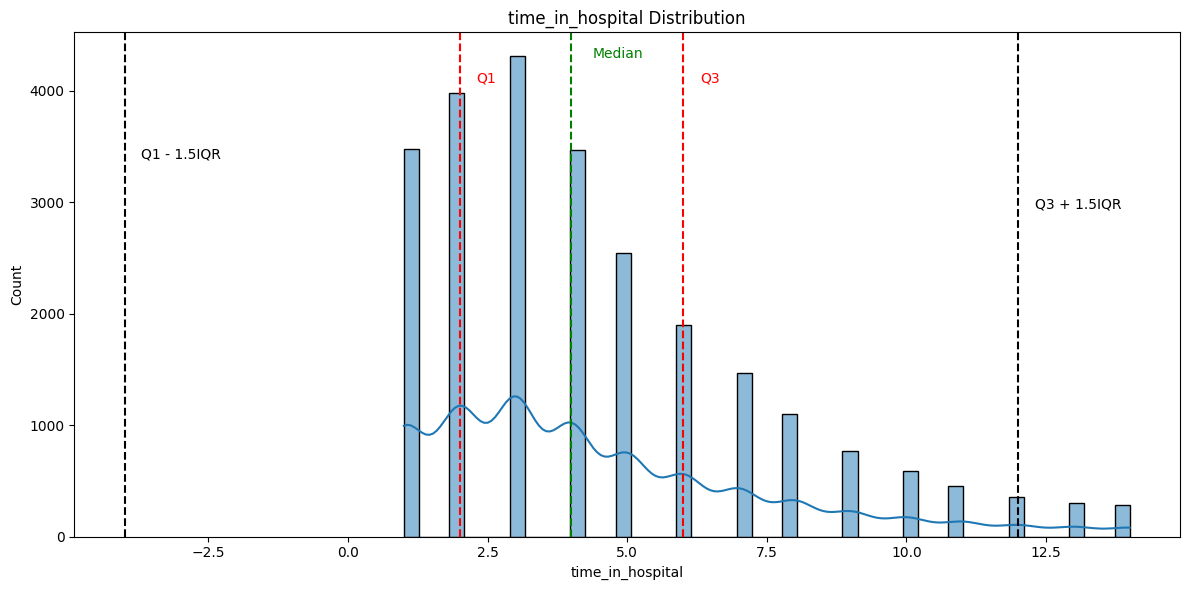

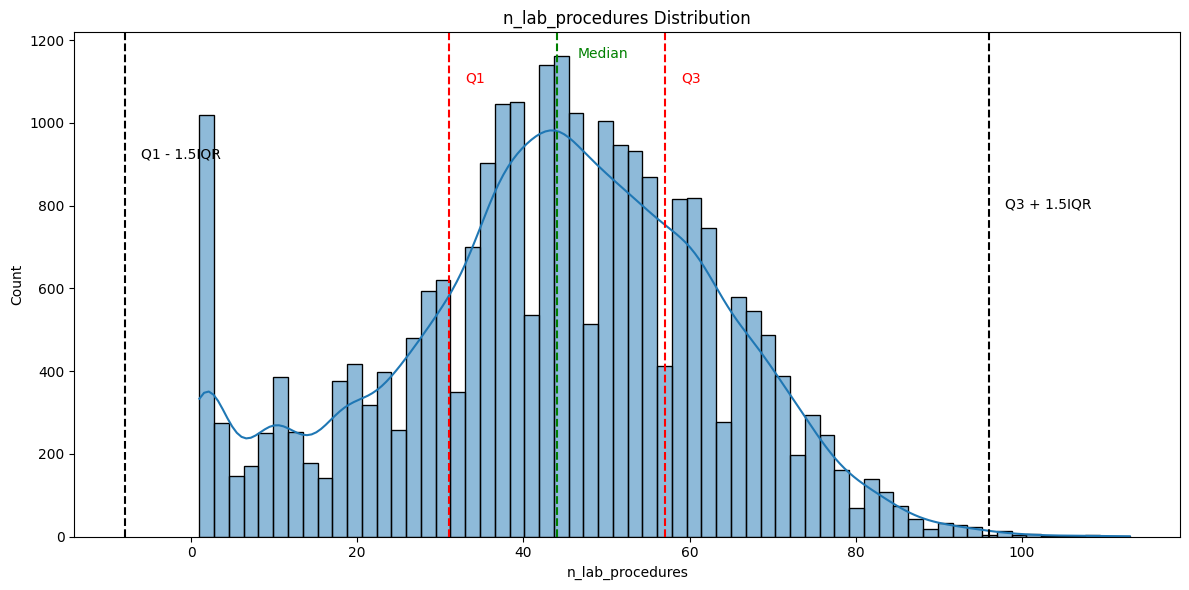

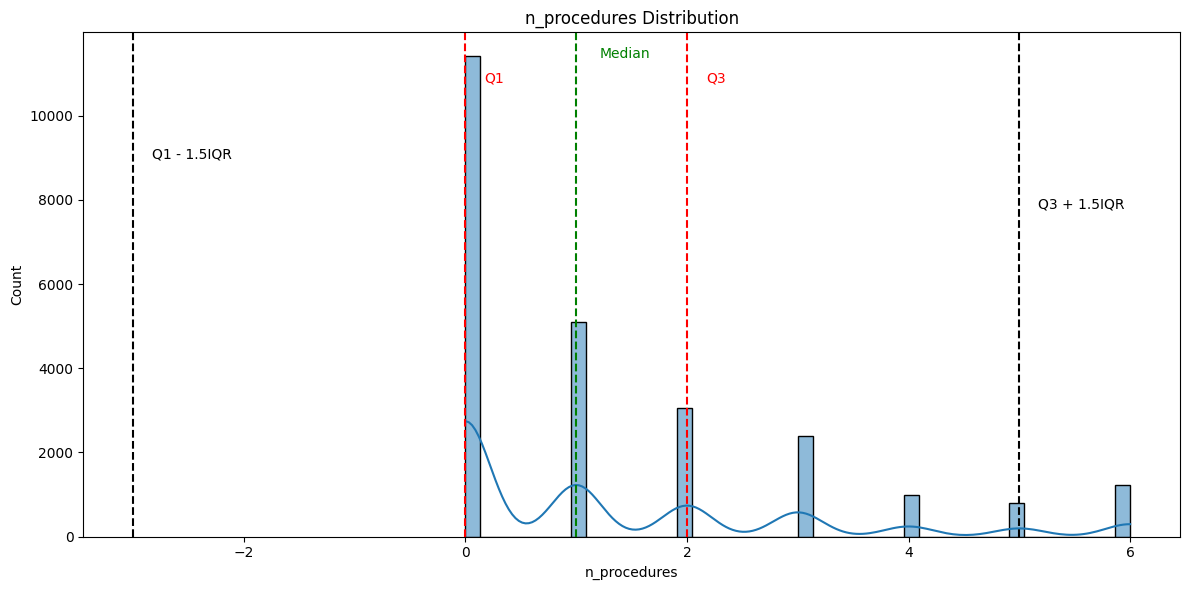

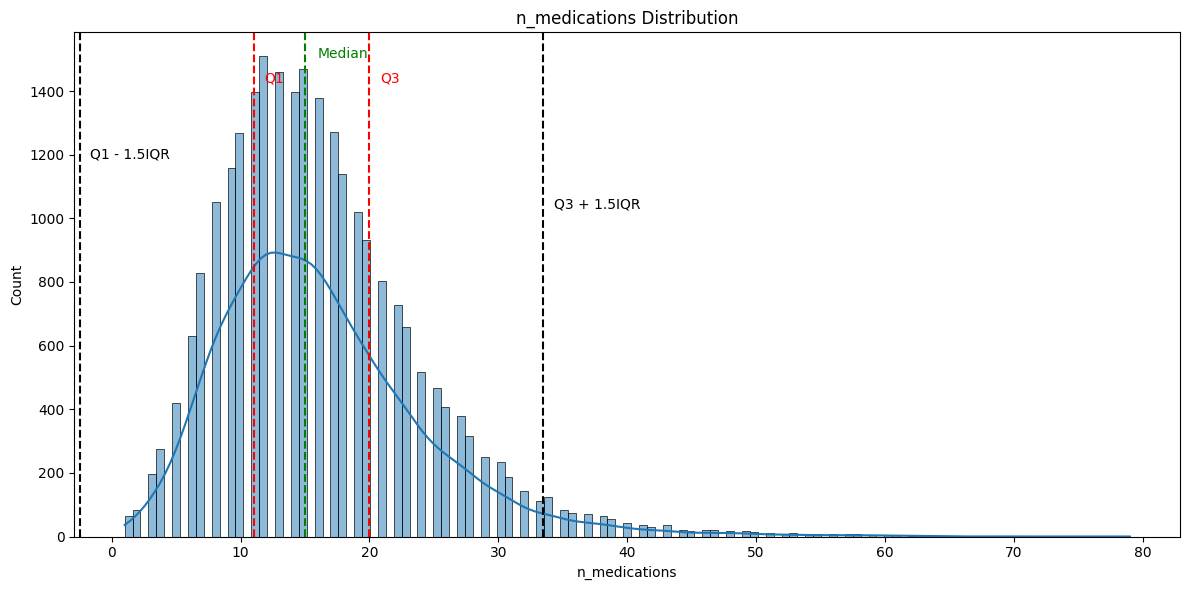

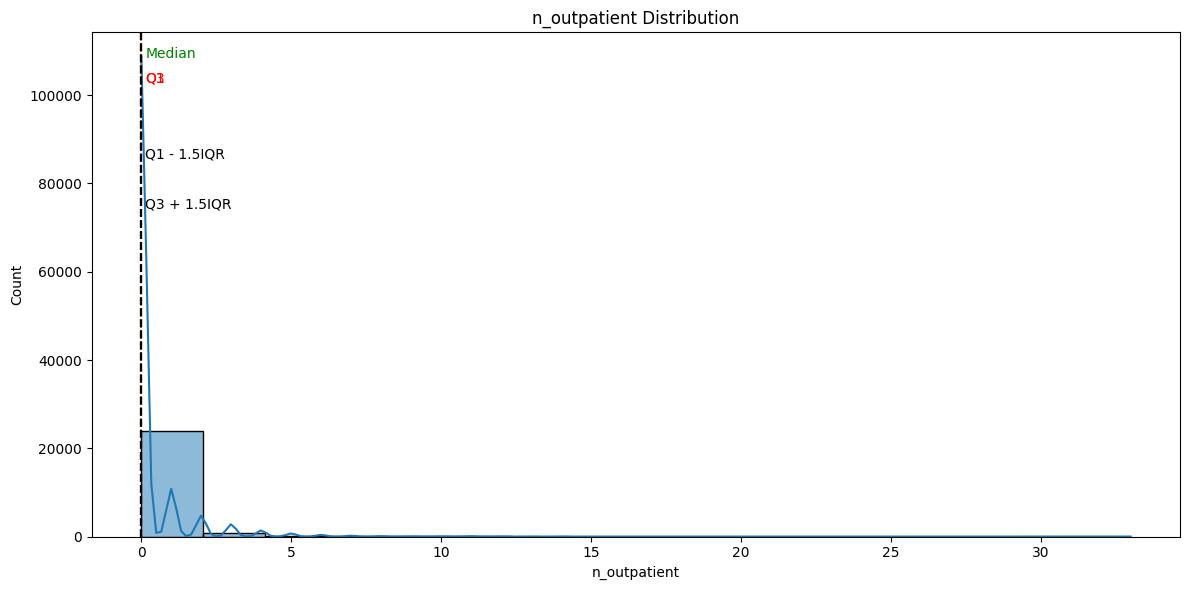

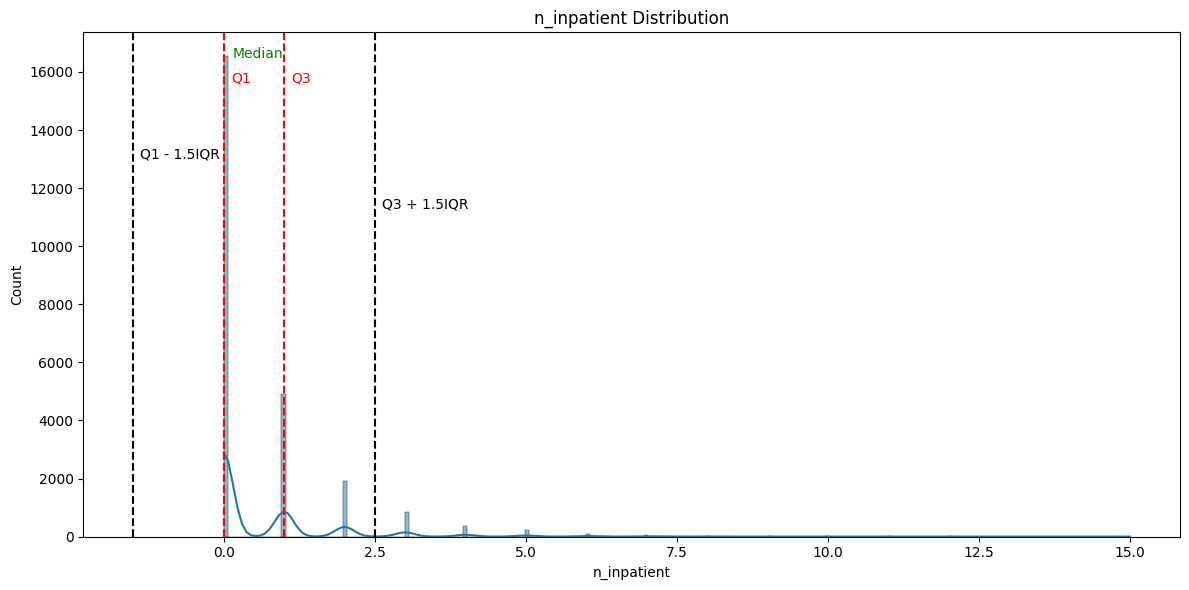

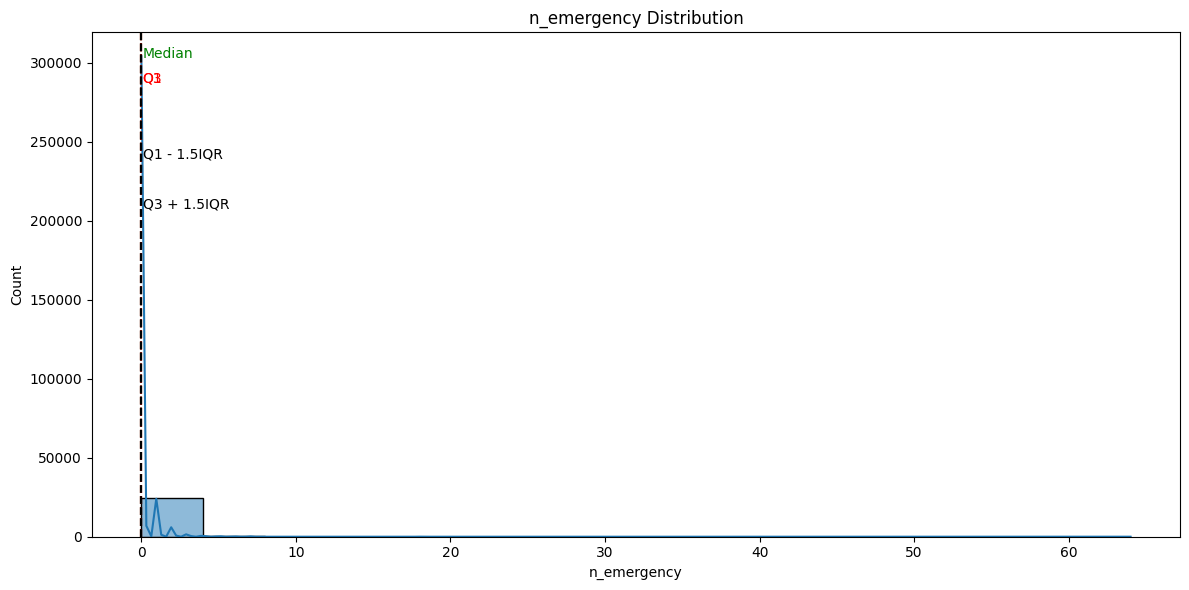

In [6]:
def plot_distribution(df, method=None):    
    for col in df:

        fig, axes = plt.subplots(figsize=(12,6))
        plt.title(f"{col} Distribution")
        sns.histplot(data=df, x=col, kde=True)

        plt.axvline(df[col].median(), color='g', linestyle='dashed', linewidth=1.5)
        plt.text(x=df[col].median() + df[col].std()/8 , y=axes.get_ylim()[1] * 0.95, s='Median', fontsize=10, c='g')

        IQR = df[col].quantile(q=0.75) - df[col].quantile(q=0.25)

        plt.axvline(df[col].quantile(q=0.25), color='r', linestyle='dashed', linewidth=1.5)
        plt.text(x=df[col].quantile(q=0.25) + df[col].std()/10, y=axes.get_ylim()[1] * 0.90, s="Q1", fontsize=10, c='r')

        plt.axvline(df[col].quantile(q=0.25) - 1.5*IQR, color='k', linestyle='dashed', linewidth=1.5)
        plt.text(x=df[col].quantile(q=0.25) - 1.5*IQR + df[col].std()/10, y=axes.get_ylim()[1] * 0.75, s="Q1 - 1.5IQR", fontsize=10, c='k')
        
        plt.axvline(df[col].quantile(q=0.75), color='r', linestyle='dashed', linewidth=1.5)
        plt.text(x=df[col].quantile(q=0.75) + df[col].std()/10, y=axes.get_ylim()[1] * 0.90, s="Q3", fontsize=10, c='r')

        plt.axvline(df[col].quantile(q=0.75) + 1.5*IQR, color='k', linestyle='dashed', linewidth=1.5)
        plt.text(x=df[col].quantile(q=0.75) + 1.5*IQR + df[col].std()/10, y=axes.get_ylim()[1] * 0.65, s="Q3 + 1.5IQR", fontsize=10, c='k')
        
        if method != None:
            plt.suptitle(f"{method}")
        plt.tight_layout()
        plt.show()
        
plot_distribution(df_numbers_features)

Below, I have decided to use the Winsorizer transformer, which caps the max and min values of a variable at automatically determined values, since our variable features have significant amount of outliers, and removing all of the outliers would have reduced a lot the amount of data.

Also, I'm using the Power Transformation and Yeo Johnson Transformation to achieve a more normalized distribution of the variables and also all the variable contain zeros. And these 2 transformers accept any positive number, including zeros. 

In [ ]:
from sklearn.pipeline import Pipeline
from feature_engine.outliers import Winsorizer
from feature_engine.transformation import PowerTransformer, YeoJohnsonTransformer

transformations_list = [PowerTransformer(), YeoJohnsonTransformer()]
method_list = ['Power Transformer', 'Yeo Johnson Transformer']

variables_irq = ['time_in_hospital', 'n_lab_procedures', 'n_procedures', 'n_medications', 'n_inpatient']
variables_mad = ['n_outpatient', 'n_emergency']
def handle_display_numerical(df, transf_list):
    for item in transf_list:
        pipeline = Pipeline([
            ('Winsorizer_iqr', Winsorizer(variables=variables_irq,
                                    capping_method='iqr',tail='both', fold=1.5)),
            ('Winsorizer_mad', Winsorizer(variables=variables_mad,
                                    capping_method='gaussian',tail='both', fold=0.05)),
            ('transformation', item)
        ])
        
        transformed_df = pipeline.fit_transform(df)
        transform_method = method_list[transformations_list.index(item)]
        
        plot_distribution(transformed_df, transform_method)
        
handle_display_numerical(df_numbers_features, transformations_list)

From the plots above, it seems the Winsorizer transformer worked well with the outliers and that the Yeo Johnson transformation achieved better distribution of the variables. However, the 'n_emergency', 'n_inpatients', 'n_outpatients' and n_procedures still need further examination, since the transformer didn't really achieve normal distribution.

### Categorical features

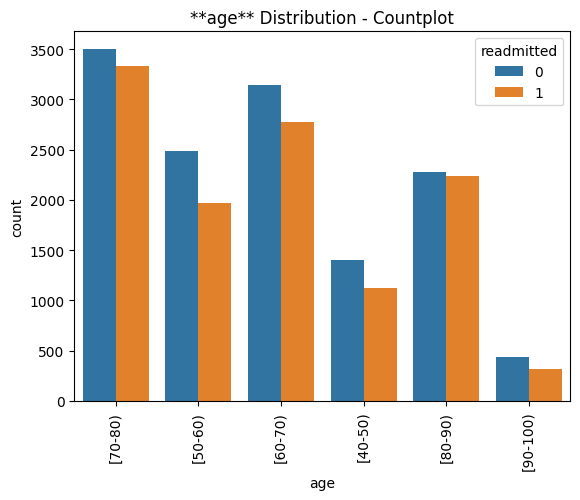

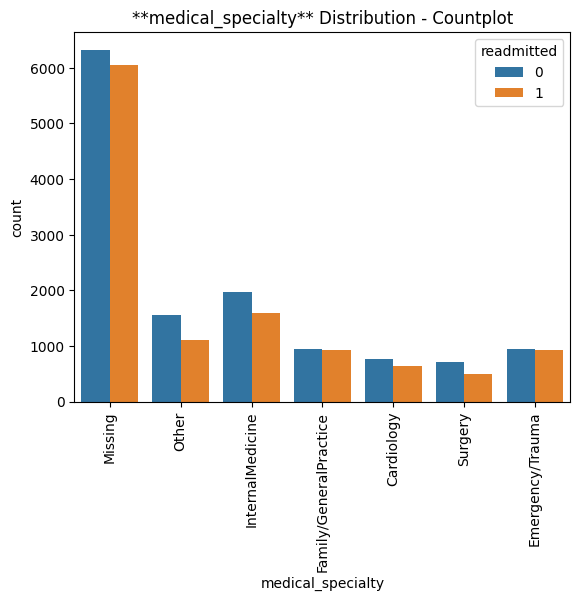

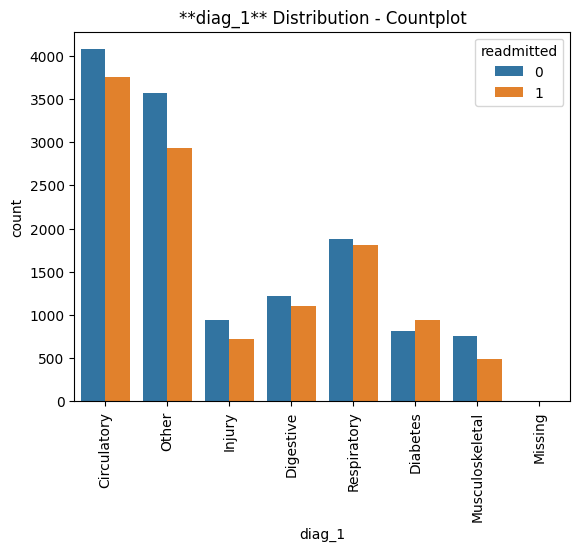

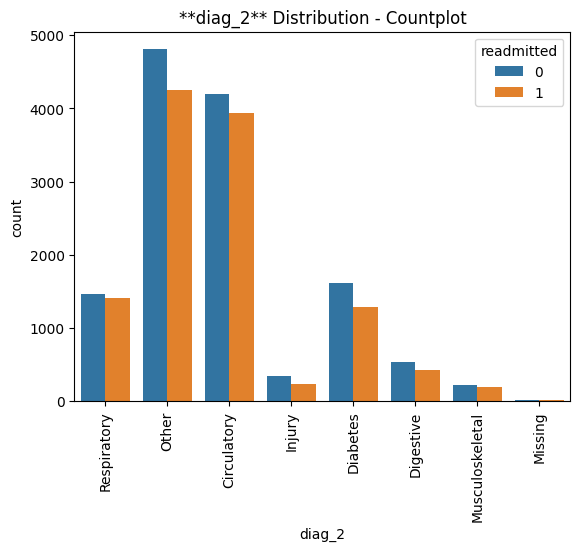

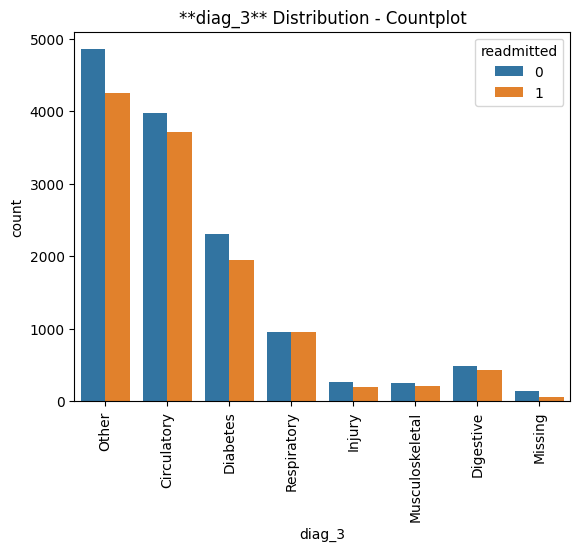

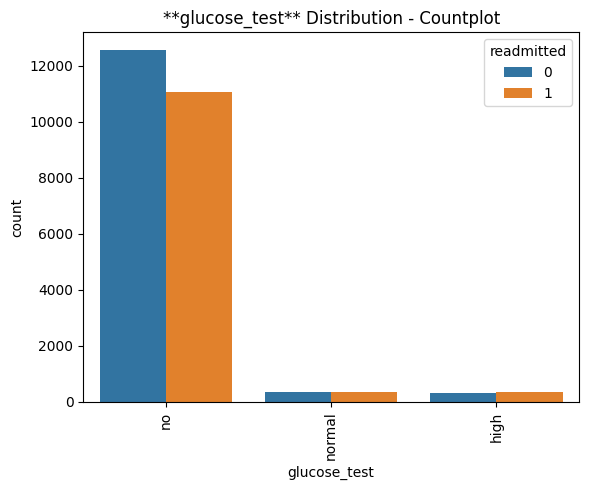

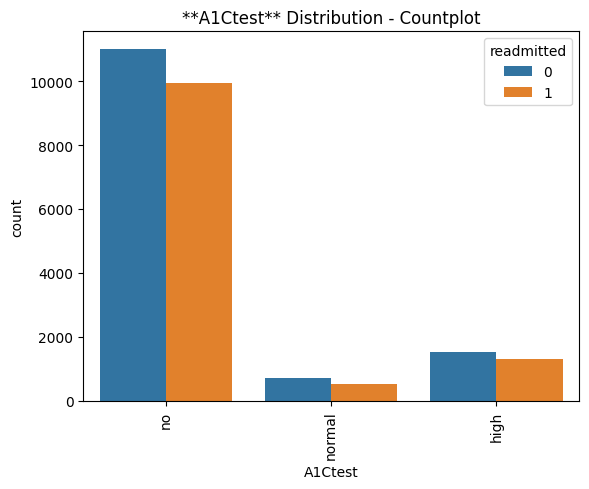

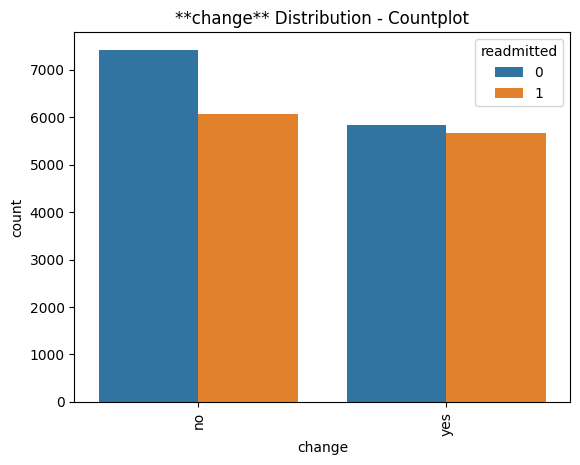

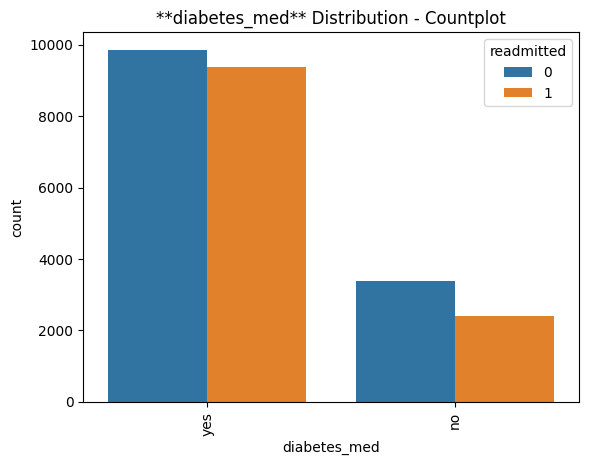

In [7]:
categorical_features = df_features.select_dtypes(include="object").columns.to_list()

for col in categorical_features:
    sns.countplot(data=df, x=col, hue=target_var)
    plt.title(f"**{col}** Distribution - Countplot")
    plt.xticks(rotation=90)
    plt.show()
    print("\n")

In [ ]:
pipeline_corr = Pipeline([
            ('Winsorizer', Winsorizer(variables=variables,
                                    capping_method='iqr',tail='both', fold=1.5)),
            ('YeoJohnsonTransformer', YeoJohnsonTransformer())
        ])

df_transformed = pipeline_corr.fit_transform(df_features)
df_correlation = df_transformed.copy()
df_correlation['readmitted'] = df['readmitted']
df_correlation.head()

## Correlation Study

In [ ]:
from feature_engine.encoding import OneHotEncoder

ohe = OneHotEncoder(variables=categorical_features, drop_last=True)
df_ohe = ohe.fit_transform(df)
print(df.shape)
df_ohe.head()

In [ ]:
corr_spearman = df_ohe.corr(method="spearman")["readmitted"].sort_values(ascending=False, key=abs)[1:].head(10)
corr_spearman

In [ ]:
corr_pearson = df_ohe.corr(method="pearson")["readmitted"].sort_values(ascending=False, key=abs)[1:].head(10)
corr_pearson

In [ ]:
top_n = 5
most_correlated_features = set(corr_spearman[:top_n].index.to_list() + corr_pearson[:top_n].index.to_list())
most_correlated_features

To further understand the factors that might contribute towards patient's readmission, we will plot the most correlate features into graphs, colored by the target variable.

In [ ]:
features_to_plot = ['diabetes_med',
 'n_emergency',
 'n_inpatient',
 'n_medications',
 'n_outpatient',
 'n_procedures',]

def plot_categorical(df, col):
    sns.countplot(df, x=col, hue=target_var)
    plt.title(f"{col}", fontsize=20, y=1.05)
    plt.show()

def plot_numerical(df, col):
    sns.histplot(df, x=col, kde=True, hue=target_var)
    plt.title(f"{col}", fontsize=20, y=1.05)
    plt.show()

for feature in features_to_plot:
    if df[feature].dtype == "object":
        plot_categorical(df, feature)
    else:
        plot_numerical(df, feature)

Below, to better visualize the patterns, we plot the above features to a parallel_categories() plot.

In [ ]:
df_parallel = df.filter(features_to_plot)
df_parallel['readmitted'] = df[target_var]
df_parallel.head()

To better plot the <strong>parallel_categories()</strong> function and avoid clutter, we are going to use the ArbitraryDiscretiser on the "n_medications" feature and create 8 bins.

In [ ]:
df['n_medications'].describe()

In [ ]:
df['n_medications'].unique()

In [ ]:
from feature_engine.discretisation import ArbitraryDiscretiser
import numpy as np

medications_map = [-np.Inf, 1, 10, 19, 28, 37, 46, 55, 64, 79,  np.Inf]
disc = ArbitraryDiscretiser(binning_dict={'n_medications': medications_map})
df_parallel_to_plot = disc.fit_transform(df_parallel)
df_parallel_to_plot.head()

In [ ]:
import plotly.express as px

fig = px.parallel_categories(df_parallel_to_plot, color=target_var)
fig.show()

From the above correlation study and and by plotting the most correlated features we notice a pattern for the readmitted patients.

* A readmitted patient receives medicines for diabetes
* A readmitted patient has 0 or very low number of emergency/inpatient/outpatient visits.
* A readmitted patient receives between 11 and 20 medicines.
* A readmitted patient has 0 or very low number of procedures.

### Predictive Power Score

In [ ]:
import ppscore as pps

pps.matrix(df)

In [ ]:
pps_matrix_raw = pps.matrix(df)
pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
print(pps_score_stats.round(3))

plt.figure(figsize=(12,8))
sns.heatmap(pps_matrix, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)
plt.show()

---

# Push files to Repo

* In case you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  os.makedirs(name='outputs\datasets\collection')
except Exception as e:
  print(e)

df_parallel.to_csv("outputs/datasets/collection/HospitalReadmissionsParallel.csv", index=False)

---

## Conclusions

From the EDA we performed above we can see that the features have very weak to weak correlation with the target variable and also the PPScore doesn't show any predictive power. The next observations we made are:

 - The numerical variables have many outliers, but the Winsorizer transformation seems to handle them well. Also, the numerical variables don't have normal distribution, which the Yeo Johnson Transformer seems to worker the best with most of the variables but the ones that still couldn't have a normal distribution they will need a different during Feature Engineering. 
 - The categorical features don't appear to have any significant imbalance and also they don't show any missing values, except the feature variables "medical_specialty", "diag_1", "diag_2" and "diag_3", which have some of their values labelled "Missing". 

Lastly, after performing a correlation study we were able to identify an initial possible pattern contributing to readmissions. But, because of the weak correlation of the features with the target variable we will consider using the SmartCorrelatedSelection transformer in the Feature Engineering notebook.

## Next Steps

Int he next notebook we will begin the Data Cleaning based on the EDA we performed here.

This will take us to the 'Data Preparation' of thr CRISP-DM workflow.